# Text classification - IMDB reviews

This notebook classifies movie reviews as positive or negative using the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

In [20]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


I'll use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

The IMDB dataset comes packaged with TensorFlow. It has already been preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

The argument num_words=10000 keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the data manageable.

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

### Exploring the data

The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Movie reviews may be different lengths and this will be solved later since the network needs inputs of same length.

In [6]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))
print(train_data[0])
len(train_data[0]), len(train_data[1])

Training entries: 25000, labels: 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


(218, 189)

### Preparing the data

Here is a helper function to query a dictionary object that contains the integer to string mapping which can be useful.

In [7]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

The reviews—the arrays of integers—must be converted to tensors before fed into the neural network. This conversion can be done a couple of ways:

1. Convert the arrays into vectors of 0s and 1s indicating word occurrence, similar to a one-hot encoding. For example, the sequence [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. This approach is memory intensive, though, requiring a num_words * num_reviews size matrix.


2. Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape max_length * num_reviews. We can use an embedding layer capable of handling this shape as the first layer in our network.

I will use the second approach since it is more memory efficient.

In [9]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [10]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [12]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

### Building the model

The layers are stacked sequentially to build the classifier:

1. The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).


2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.


3. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.


4. The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

The choosen loss function is the binary_crossentropy which is good for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions, specifically for binary classifications in comparison to the categorical_crossentropy. The optimizer is the classical and one of the best, the adam optimizer.

In [15]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)

def build_model():
    vocab_size = 10000

    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, 16))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(16, activation=tf.nn.relu))
    model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
    
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### Training the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the train_data and train_labels tensors with exception to the validation set data. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [16]:
model = build_model()

history = model.fit(train_data,
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_split=0.4,
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 73us/sample - loss: 0.6916 - acc: 0.6015 - val_loss: 0.6888 - val_acc: 0.7208
Epoch 2/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6840 - acc: 0.7315 - val_loss: 0.6780 - val_acc: 0.7393
Epoch 3/40
15000/15000 [==============================] - 1s 48us/sample - loss: 0.6686 - acc: 0.7635 - val_loss: 0.6586 - val_acc: 0.7592
Epoch 4/40
15000/15000 [==============================] - 1s 50us/sample - loss: 0.6432 - acc: 0.7879 - val_loss: 0.6294 - val_acc: 0.7754
Epoch 5/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6074 - acc: 0.8043 - val_loss: 0.5923 - val_acc: 0.7913
Epoch 6/40
15000/15000 [==============================] - 1s 48us/sample - loss: 0.5642 - acc: 0.8229 - val_loss: 0.5510 - val_acc: 0.8020
Epoch 7/40
15000/15000 [==============================] - 1s 49us/sa

### Evaluating the model

This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

In [18]:
results = model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 1s 22us/sample - loss: 0.3315 - acc: 0.8714


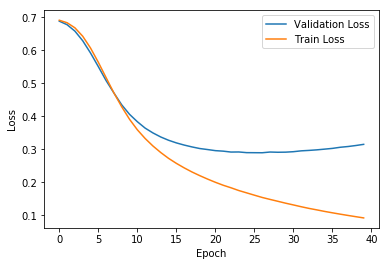

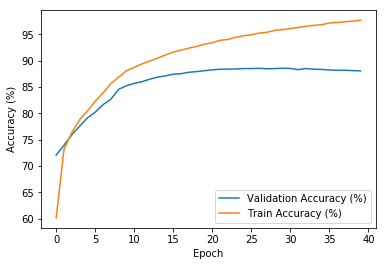

In [21]:
def plot_history(history, metric='loss', label='Loss', scaling=1):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.plot(hist['epoch'], hist['val_' + metric]*scaling,
           label='Validation ' + label)
    plt.plot(hist['epoch'], hist[metric]*scaling,
           label='Train ' + label)
    plt.legend()

plot_history(history)
plot_history(history, 'acc', 'Accuracy (%)', 100)

### Re-training an re-evaluating the model

The validation loss and accuracy seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data. So an early stop callback is desirable here.

In [30]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model = build_model()

history = model.fit(train_data,
                    train_labels,
                    epochs=100,
                    batch_size=512,
                    validation_split=0.4,
                    callbacks=[early_stop],
                    verbose=2)

Train on 15000 samples, validate on 10000 samples
Epoch 1/100
 - 1s - loss: 0.6923 - acc: 0.5250 - val_loss: 0.6906 - val_acc: 0.5725
Epoch 2/100
 - 1s - loss: 0.6871 - acc: 0.5992 - val_loss: 0.6824 - val_acc: 0.6260
Epoch 3/100
 - 1s - loss: 0.6742 - acc: 0.6957 - val_loss: 0.6656 - val_acc: 0.6794
Epoch 4/100
 - 1s - loss: 0.6510 - acc: 0.7441 - val_loss: 0.6376 - val_acc: 0.7501
Epoch 5/100
 - 1s - loss: 0.6158 - acc: 0.7727 - val_loss: 0.5996 - val_acc: 0.7791
Epoch 6/100
 - 1s - loss: 0.5709 - acc: 0.8100 - val_loss: 0.5558 - val_acc: 0.8059
Epoch 7/100
 - 1s - loss: 0.5214 - acc: 0.8325 - val_loss: 0.5105 - val_acc: 0.8243
Epoch 8/100
 - 1s - loss: 0.4719 - acc: 0.8556 - val_loss: 0.4684 - val_acc: 0.8297
Epoch 9/100
 - 1s - loss: 0.4262 - acc: 0.8679 - val_loss: 0.4314 - val_acc: 0.8459
Epoch 10/100
 - 1s - loss: 0.3870 - acc: 0.8807 - val_loss: 0.4017 - val_acc: 0.8506
Epoch 11/100
 - 1s - loss: 0.3534 - acc: 0.8883 - val_loss: 0.3780 - val_acc: 0.8579
Epoch 12/100
 - 1s - los

We can verify that the early stopping saves training time and gives a sligthly better model.

In [31]:
results = model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 1s 25us/sample - loss: 0.3038 - acc: 0.8754


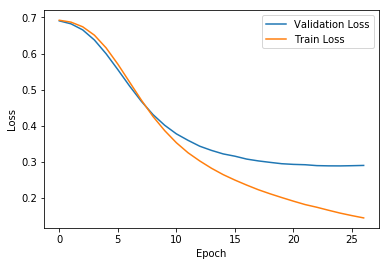

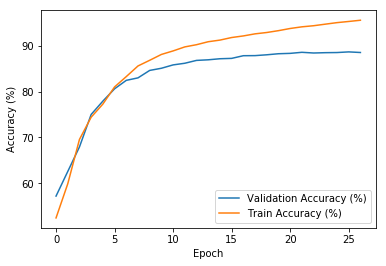

In [32]:
plot_history(history)
plot_history(history, 'acc', 'Accuracy (%)', 100)